In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

In [17]:
# import data 
DATASET_SIZE = 70000
TRAIN_RATIO = 0.7
VALIDATION_RATIO = 0.2
TEST_RATIO = 0.1

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test])

x_train_orig, x_valid_orig, y_train_orig, y_valid_orig = train_test_split(x, y, test_size=(1-TRAIN_RATIO))
x_valid_orig, x_test_orig, y_valid_orig, y_test_orig = train_test_split(x_valid_orig, y_valid_orig, test_size=((TEST_RATIO/(VALIDATION_RATIO+TEST_RATIO))))

In [18]:
# compress the image 
def image_compress(x, k=2): 
    comp_size = int(28/k)
    x_temp = x.reshape(28,28)
    x_comp = np.zeros(comp_size * comp_size).reshape(comp_size, comp_size)
    for i in range(0, comp_size): 
        for j in range(0, comp_size): 
            avg = x_temp[k*i:k*(i+1), k*j:k*(j+1)]
            x_comp[i,j] = np.mean(avg)
    x_comp = x_comp.reshape(comp_size * comp_size)
    return x_comp

In [19]:
k=4

# compress the images 
n_train = np.shape(x_train_orig)[0]
#n_train = 1000
x_train_comp = []
for i in range(n_train): 
    x_train_comp = np.append(x_train_comp, image_compress(x_train_orig[i], k))
x_train_comp = x_train_comp.reshape((n_train, -1))

n_valid = np.shape(x_valid_orig)[0]
#n_valid = 100
x_valid_comp = []
for i in range(n_valid): 
    x_valid_comp = np.append(x_valid_comp, image_compress(x_valid_orig[i], k))
x_valid_comp = x_valid_comp.reshape((n_valid, -1))

n_test = np.shape(x_test_orig)[0]
#n_test = 100
x_test_comp = []
for i in range(n_test): 
    x_test_comp = np.append(x_test_comp, image_compress(x_test_orig[i], k))
x_test_comp = x_test_comp.reshape((n_test, -1))
    
# normalize data 
x_train = x_train_comp.astype('float32')/255.
y_train = y_train_orig

x_valid = x_valid_comp.astype('float32')/255.
y_valid = y_valid_orig

x_test = x_test_comp.astype('float32')/255.
y_test = y_test_orig 

In [20]:
# define model 
# Neural network 

input_size = int((28/k)**2)
m_size = 2**5
hidden_size = 128
output_size = 10

# encoding 
input_img = tf.keras.Input(shape=(input_size,))


# middle layer 
m_layer = Dense(m_size, activation='relu')(input_img) # cos 
    #m_layer = Dense(m_size, activation='relu')(h2_layer)

output_img = Dense(output_size, activation='sigmoid')(m_layer) # linear 

model = Model(input_img, output_img)

print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 49)]              0         
                                                                 
 dense_4 (Dense)             (None, 32)                1600      
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
Total params: 1,930
Trainable params: 1,930
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
# training setting 
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', 
              metrics=['accuracy'])

M = 200
seed = 1
tf.random.set_seed(seed)
history = model.fit(x=x_train, y=y_train, validation_data = (x_valid, y_valid), 
          epochs=M, batch_size=32, verbose=2)

Epoch 1/200
1532/1532 - 2s - loss: 1.9256 - accuracy: 0.4837 - val_loss: 1.4815 - val_accuracy: 0.7006 - 2s/epoch - 1ms/step
Epoch 2/200
1532/1532 - 1s - loss: 1.1555 - accuracy: 0.7505 - val_loss: 0.9083 - val_accuracy: 0.7838 - 1s/epoch - 810us/step
Epoch 3/200
1532/1532 - 1s - loss: 0.7994 - accuracy: 0.7999 - val_loss: 0.6984 - val_accuracy: 0.8171 - 1s/epoch - 778us/step
Epoch 4/200
1532/1532 - 1s - loss: 0.6565 - accuracy: 0.8258 - val_loss: 0.5996 - val_accuracy: 0.8391 - 1s/epoch - 786us/step
Epoch 5/200
1532/1532 - 1s - loss: 0.5831 - accuracy: 0.8407 - val_loss: 0.5447 - val_accuracy: 0.8503 - 1s/epoch - 765us/step
Epoch 6/200
1532/1532 - 1s - loss: 0.5394 - accuracy: 0.8513 - val_loss: 0.5094 - val_accuracy: 0.8575 - 1s/epoch - 821us/step
Epoch 7/200
1532/1532 - 1s - loss: 0.5108 - accuracy: 0.8576 - val_loss: 0.4853 - val_accuracy: 0.8611 - 1s/epoch - 787us/step
Epoch 8/200
1532/1532 - 1s - loss: 0.4903 - accuracy: 0.8620 - val_loss: 0.4681 - val_accuracy: 0.8661 - 1s/epoch

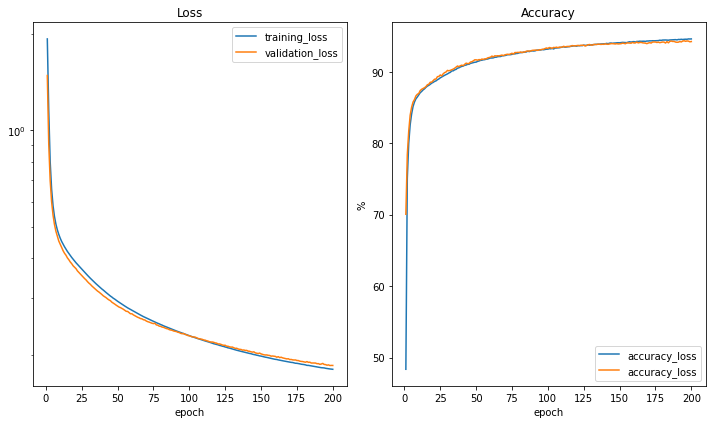

In [22]:
loss_train = history.history['loss']
loss_valid = history.history['val_loss']
accuracy_train = history.history['accuracy']
accuracy_train = np.reshape(accuracy_train, (M,1))
accuracy_valid = history.history['val_accuracy']
accuracy_valid = np.reshape(accuracy_valid, (M,1))


plt.figure(figsize=(10, 6))
epoch_list = np.arange(1, M+1)
plt.subplot(1, 2,  1)
plt.semilogy(epoch_list, loss_train, label = 'training_loss')
plt.semilogy(epoch_list, loss_valid, label = 'validation_loss')
plt.legend()
plt.xlabel('epoch')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(epoch_list, accuracy_train*100, label = 'accuracy_loss')
plt.plot(epoch_list, accuracy_valid*100, label = 'accuracy_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('%')
plt.title('Accuracy')
plt.tight_layout()
plt.show()

In [23]:
pred = model.predict(x_test)
pred = np.argmax(pred, 1)
accuracy = np.mean((pred==y_test).astype('int'))
accuracy

0.9428653049564348